Un problème courant de classification de l'apprentissage automatique consiste à différencier deux catégories
<p>dans cet exemple : différencier entre les radiographies abdominales et thoraciques.

In [34]:
# Import keras module
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
import os

path = os.path.join('archive', 'data')

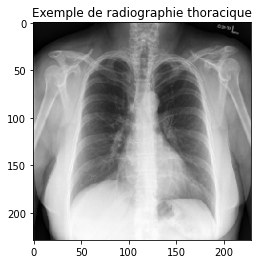

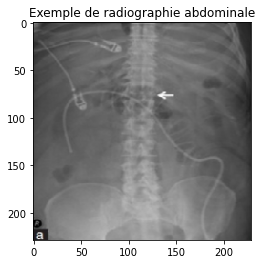

In [36]:
train_dir = os.path.join(path, 'train')
val_dir = os.path.join(path, 'val')

num_train = 65
num_val = 10

import numpy as np    
from keras.preprocessing import image
import matplotlib.pyplot as plt    

img_width, img_height = 299, 299

img_path = os.path.join(train_dir, 'chst\chst33.png')
img = image.load_img(img_path, target_size=(229, 229))
plt.imshow(img)
plt.title('Exemple de radiographie thoracique')
plt.show()

# set the path to an abdominal radiograph, then load it and show
img2_path = os.path.join(train_dir, 'abd/abd1.png')
img2 = image.load_img(img2_path, target_size=(229, 229))
plt.imshow(img2)
plt.title("Exemple de radiographie abdominale")
plt.show()

In [17]:
# set the batch size for each training step
batch_size = 8

In [15]:

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
)

print('ok!')

Success!


In [18]:

print("Training generator: ", end="")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


val_datagen = ImageDataGenerator(rescale=1./255)
print("Validation generator: ", end="")
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Training generator: Found 65 images belonging to 2 classes.
Validation generator: Found 10 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications import InceptionV3

In [3]:
modelxx= InceptionV3()
modelxx.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:

backbone = applications.InceptionV3( include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the  weights in the model backbone
for layer in backbone.layers:
    layer.trainable = False

print('Model backbone initialized!')    # this will print when this step is complete

87916544/87910968 [==============================] - 114s 1us/step
Model backbone initialized!


In [20]:
# create the top layers of the model
model_top = Sequential()    # initialize as a Sequential model (i.e. no recurrent layers)
model_top.add(GlobalAveragePooling2D(input_shape=backbone.output_shape[1:], data_format=None)) 
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid')) 

# connect "model_top" to "backbone"
model = Model(inputs=backbone.input, outputs=model_top(backbone.output))

# compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

print('Setup Complete!')

Setup Complete!


In [22]:
print(model_top.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 524,801
Trainable params: 524,801
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# set the number of epochs for training
epochs = 4

# train the model and save the training/validation results for each epoch to "history"
history = model.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=num_val // batch_size)

print('Training complete!')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/4
8/8 [==============================] - 8s 1s/step - loss: 0.7997 - accuracy: 0.5263 - val_loss: 0.6677 - val_accuracy: 0.5000
Epoch 2/4
8/8 [==============================] - 7s 841ms/step - loss: 0.5375 - accuracy: 0.7719 - val_loss: 0.4941 - val_accuracy: 1.0000
Epoch 3/4
8/8 [==============================] - 8s 1s/step - loss: 0.3902 - accuracy: 0.8947 - val_loss: 0.3788 - val_accuracy: 1.0000
Epoch 4/4
8/8 [==============================] - 7s 826ms/step - loss: 0.3670 - accuracy: 0.9123 - val_loss: 0.3587 - val_accuracy: 1.0000
Training complete!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


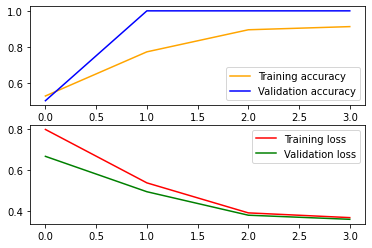

In [25]:
print(history.history.keys())

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['accuracy'], 'orange', label='Training accuracy')
ax[0].plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
ax[1].plot(history.history['loss'], 'red', label='Training loss')
ax[1].plot(history.history['val_loss'], 'green', label='Validation loss')
ax[0].legend()
ax[1].legend()
plt.show()

In [26]:
for layer in model.layers:
    layer.trainable = True

# When you make a change to the model, you have to compile it again prior to training
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

print('Setup Complete!')

Setup Complete!


In [27]:
# set the number of epochs for training
epochs = 3

# train the model and save the training/validation results for each epoch to "history"
history = model.fit(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=num_val // batch_size)

print('Training complete!')

Epoch 1/3
8/8 [==============================] - 36s 4s/step - loss: 0.4076 - accuracy: 0.8947 - val_loss: 0.8462 - val_accuracy: 0.5000
Epoch 2/3
8/8 [==============================] - 35s 4s/step - loss: 0.0961 - accuracy: 0.9825 - val_loss: 0.7237 - val_accuracy: 0.5000
Epoch 3/3
8/8 [==============================] - 37s 5s/step - loss: 0.0969 - accuracy: 0.9649 - val_loss: 0.4260 - val_accuracy: 0.7500
Training complete!


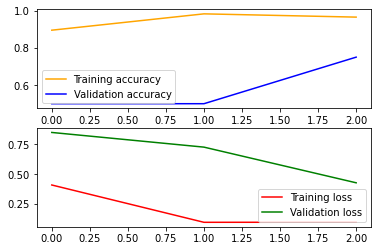

In [28]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['accuracy'], 'orange', label='Training accuracy')
ax[0].plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
ax[1].plot(history.history['loss'], 'red', label='Training loss')
ax[1].plot(history.history['val_loss'], 'green', label='Validation loss')
ax[0].legend()
ax[1].legend()
plt.show()

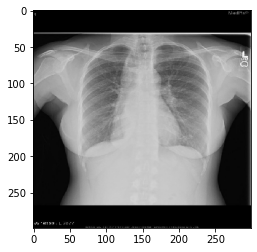

Predicted:( 0.99928147 ) radiographie thoracique


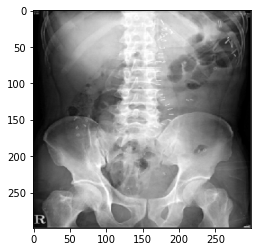

Predicted:( 0.377933 radiographie abdominale


In [32]:
# load example chest and abdominal radiographs from test data set 
img_path = os.path.join(path, 'test/chest_test.png')
img_path2 = os.path.join(path, 'test/abd_test.png')
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))

# show the chest radiograph
plt.imshow(img)
plt.show()

# evaluate the chest radiograph with the model, then print the model's prediction
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255
score = model.predict(x)
print('Predicted:(', score[0][0], ') radiographie thoracique' if score > 0.5 else 'radiographie abdominale')

# show the abdominal radiograph
plt.imshow(img2)
plt.show()

# evaluate the abdominal radiograph with the model, then print the model's prediction
img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:(', score2[0][0], ') radiographie thoracique' if score2 > 0.5 else 'radiographie abdominale')

Inférence sur deux cas de test. Les nombres entre parenthèses représentent la probabilité d'une radiographie thoracique par rapport à une radiographie abdominale (intervalle de 0 à 1). Un score proche de 1 indique une haute confiance d'une radiographie thoracique, et un score proche de 0 indique une haute confiance d'une radiographie abdominale